# Hail Introduction

Tutorial snippet from: https://hail.is/docs/stable/tutorials/hail-overview.html

We begin with some imports.

In [1]:
from hail import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline

Each notebook starts the same: creating a `HailContext`. Below, we do this and read in a vds from hdfs.

In [2]:
hc = HailContext()
vds = hc.read('gs://hail-1kg/ALL.1KG.800K.vds/').split_multi()
vds.summarize().report()


         Samples: 2535
        Variants: 838153
       Call Rate: 0.977206
         Contigs: ['X', '12', '8', '19', '4', '15', '11', '9', '22', '13', '16', '5', '10', '21', '6', '1', '17', '14', '20', '2', '18', '7', '3']
   Multiallelics: 0
            SNPs: 714348
            MNPs: 0
      Insertions: 52666
       Deletions: 71137
 Complex Alleles: 2
    Star Alleles: 0
     Max Alleles: 2


The query_variants method is the first time we’ll see the Hail expression language. The expression language allows for a variety of incredibly expressive queries and computations, but is probably the most complex part of Hail. See the pair of tutorials on the expression language to learn more!

In [3]:
vds.query_variants('variants.take(5)')

[Variant(contig=7, start=8104099, ref=C, alts=[AltAllele(ref=C, alt=T)]),
 Variant(contig=7, start=8107521, ref=G, alts=[AltAllele(ref=G, alt=T)]),
 Variant(contig=7, start=8109080, ref=G, alts=[AltAllele(ref=G, alt=T)]),
 Variant(contig=7, start=8111063, ref=G, alts=[AltAllele(ref=G, alt=C)]),
 Variant(contig=7, start=8116467, ref=T, alts=[AltAllele(ref=T, alt=C)])]

There are often several ways to do something in Hail. Here are two ways to peek at the first few sample IDs:

In [4]:
vds.query_samples('samples.take(5)')

[u'HG00096', u'HG00097', u'HG00099', u'HG00100', u'HG00101']

In [5]:
vds.sample_ids[:5]

[u'HG00096', u'HG00097', u'HG00099', u'HG00100', u'HG00101']

There’s a similar interface for looking at the genotypes in a dataset. We use `query_genotypes` to look at the first few genotype calls.

In [6]:
vds.query_genotypes('gs.take(5)')

[Genotype(GT=0, AD=[4, 0], DP=4, GQ=12, PL=[0, 12, 167]),
 Genotype(GT=0, AD=[3, 0], DP=3, GQ=9, PL=[0, 9, 112]),
 Genotype(GT=0, AD=[2, 0], DP=2, GQ=6, PL=[0, 6, 78]),
 Genotype(GT=0, AD=[11, 0], DP=11, GQ=33, PL=[0, 33, 410]),
 Genotype(GT=0, AD=[3, 0], DP=3, GQ=9, PL=[0, 9, 118])]

## Integrate Sample Annotations

The annotations file can be imported into Hail with HailContext.import_table. This method produces a KeyTable object. Think of this as a Pandas or R dataframe that isn’t limited by the memory on your machine – behind the scenes, it’s distributed with Spark.

In [7]:
table = hc.import_table('gs://hail-1kg/1kg-silly.sample_annotations', impute=True)\
    .key_by('Sample')

A good way to peek at the structure of a `KeyTable` is to look at its `schema.`

In [8]:
print(table.schema)

Struct{Sample:String,Population:String,SuperPopulation:String,isFemale:Boolean,PurpleHair:Boolean,CaffeineConsumption:Double}


The Python pprint method makes illegible printouts pretty:

In [9]:
pprint(table.schema)

Struct{
     Sample: String,
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Double
 }


Now we’ll use this table to add sample annotations to our dataset. First, we’ll print the schema of the sample annotations already there:

In [10]:
pprint(vds.sample_schema)

Empty


We use the annotate_samples_table method to join the table with the VDS.

In [11]:
vds = vds.annotate_samples_table(table, root='sa')
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Double
 }


## Query Functions and the Hail Expression Language

We start by looking at some statistics of the information in our table. The query method uses the expression language to aggregate over the rows of the table.

`counter` is an aggregation function that counts the number of occurrences of each unique element. We can use this to pull out the population distribution.

In [12]:
pprint(table.query('SuperPopulation.counter()'))

{u'AFR': 1018L, u'AMR': 535L, u'EAS': 617L, u'EUR': 669L, u'SAS': 661L}


`stats` is an aggregation function that produces some useful statistics about numeric collections. We can use this to see the distribution of the CaffeineConsumption phenotype.

In [13]:
pprint(table.query('CaffeineConsumption.stats()'))

{u'max': 83.0,
 u'mean': 67.07599999999991,
 u'min': 53.0,
 u'nNotMissing': 3500L,
 u'stdev': 4.574831269331922,
 u'sum': 234765.99999999968}


However, these metrics aren’t perfectly representative of the samples in our dataset. Here’s why:

In [14]:
vds.query_samples('samples.map(s => sa.SuperPopulation).counter()')

{u'AFR': 669L, u'AMR': 352L, u'EAS': 515L, u'EUR': 505L, u'SAS': 494L}

In [15]:
pprint(vds.query_samples('samples.map(s => sa.CaffeineConsumption).stats()'))

{u'max': 81.0,
 u'mean': 67.0339250493096,
 u'min': 53.0,
 u'nNotMissing': 2535L,
 u'stdev': 4.560316022725173,
 u'sum': 169930.99999999985}


The functionality demonstrated in the last few cells isn’t anything especially new: it’s certainly not difficult to ask these questions with Pandas or R dataframes, or even Unix tools like awk. But Hail can use the same interfaces and query language to analyze collections that are much larger, like the set of variants.

Here we calculate the counts of each of the 12 possible unique SNPs (4 choices for the reference base * 3 choices for the alternate base). To do this, we need to map the variants to their alternate allele, filter to SNPs, and count by unique ref/alt pair:

In [16]:
snp_counts = vds.query_variants('variants.map(v => v.altAllele()).filter(aa => aa.isSNP()).counter()')
pprint(Counter(snp_counts).most_common())

[(AltAllele(ref=C, alt=T), 142527L),
 (AltAllele(ref=G, alt=A), 142293L),
 (AltAllele(ref=T, alt=C), 98288L),
 (AltAllele(ref=A, alt=G), 98155L),
 (AltAllele(ref=C, alt=A), 33506L),
 (AltAllele(ref=G, alt=T), 33060L),
 (AltAllele(ref=G, alt=C), 30558L),
 (AltAllele(ref=C, alt=G), 30268L),
 (AltAllele(ref=T, alt=G), 28380L),
 (AltAllele(ref=A, alt=C), 28253L),
 (AltAllele(ref=A, alt=T), 24542L),
 (AltAllele(ref=T, alt=A), 24518L)]


It’s nice to see that we can actually uncover something biological from this small dataset: we see that these frequencies come in pairs. C/T and G/A are actually the same mutation, just viewed from from opposite strands. Likewise, T/A and A/T are the same mutation on opposite strands. There’s a 30x difference between the frequency of C/T and A/T SNPs. Why?

The same Python, R, and Unix tools could do this work as well, but we’re starting to hit a wall - the latest gnomAD release publishes about 250 million variants, and that won’t fit in memory on a single computer.

What about genotypes? Hail can query the collection of all genotypes in the dataset, and this is getting large even for our tiny dataset. Our 1,000 samples and 10,000 variants produce 10 million unique genotypes. The gnomAD dataset has about 5 trillion unique genotypes.

Here we will use the hist aggregator to produce and plot a histogram of DP values for genotypes in our thousand genomes dataset.

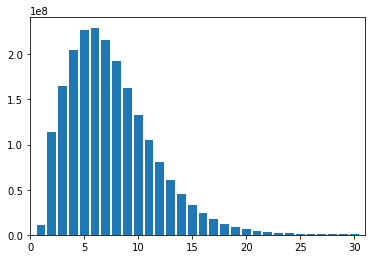

In [17]:
dp_hist = vds.query_genotypes('gs.map(g => g.dp).hist(0, 30, 30)')
plt.xlim(0, 31)
plt.bar(dp_hist.binEdges[1:], dp_hist.binFrequencies)
plt.show()

## Quality Control

QC is where analysts spend most of their time with sequencing datasets. QC is an iterative process, and is different for every project: there is no “push-button” solution for QC. Each time the Broad collects a new group of samples, it finds new batch effects. However, by practicing open science and discussing the QC process and decisions with others, we can establish a set of best practices as a community.

QC is entirely based on the ability to understand the properties of a dataset. Hail attempts to make this easier by providing the sample_qc method, which produces a set of useful metrics as sample annotations.

In [18]:
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Double
 }


In [19]:
vds = vds.sample_qc()
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Double,
     qc: Struct{
         callRate: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         nSNP: Int,
         nInsertion: Int,
         nDeletion: Int,
         nSingleton: Int,
         nTransition: Int,
         nTransversion: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rTiTv: Double,
         rHetHomVar: Double,
         rInsertionDeletion: Double
     }
 }


Interoperability is a big part of Hail. We can pull out these new metrics to a Pandas dataframe with one line of code:

In [20]:
df = vds.samples_table().to_pandas()
df.head()

,s,sa.Population,sa.SuperPopulation,sa.isFemale,sa.PurpleHair,sa.CaffeineConsumption,sa.qc.callRate,sa.qc.nCalled,sa.qc.nNotCalled,sa.qc.nHomRef,...,sa.qc.nTransition,sa.qc.nTransversion,sa.qc.dpMean,sa.qc.dpStDev,sa.qc.gqMean,sa.qc.gqStDev,sa.qc.nNonRef,sa.qc.rTiTv,sa.qc.rHetHomVar,sa.qc.rInsertionDeletion
0,HG00096,GBR,EUR,False,False,77.0,0.965758,809453,28700,719381,...,72692,35453,4.366649,2.378443,15.459878,13.037184,90072,2.050377,1.045510,1.035838
1,HG00097,GBR,EUR,True,True,67.0,0.990115,829868,8285,730755,...,75498,37129,8.626977,3.905912,29.803904,18.507187,99113,2.033397,1.472262,1.111809
2,HG00099,GBR,EUR,True,False,64.0,0.982671,823629,14524,727480,...,75003,36585,7.351780,3.864504,25.510748,18.014715,96149,2.050103,1.340132,1.064392
3,HG00100,GBR,EUR,True,False,59.0,0.997518,836073,2080,733106,...,77025,37665,12.031569,4.467401,40.238605,19.649615,102967,2.045002,1.645267,0.926214
4,HG00101,GBR,EUR,False,True,77.0,0.989422,829287,8866,732142,...,75106,36909,6.381239,3.058402,22.248394,15.784409,97145,2.034897,1.355316,1.113551


Plotting the QC metrics is a good place to start.

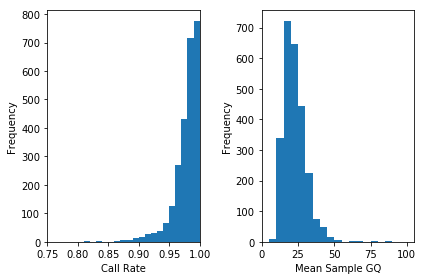

In [21]:
plt.clf()
plt.subplot(1, 2, 1)
plt.hist(df["sa.qc.callRate"], bins=np.arange(.75, 1.01, .01))
plt.xlabel("Call Rate")
plt.ylabel("Frequency")
plt.xlim(.75, 1)

plt.subplot(1, 2, 2)
plt.hist(df["sa.qc.gqMean"], bins = np.arange(0, 105, 5))
plt.xlabel("Mean Sample GQ")
plt.ylabel("Frequency")
plt.xlim(0, 105)

plt.tight_layout()
plt.show()

Often, these metrics are correlated.

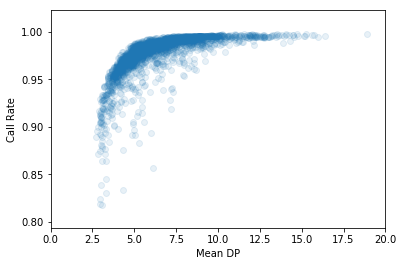

In [22]:
plt.scatter(df["sa.qc.dpMean"], df["sa.qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.show()

Removing outliers from the dataset will generally improve association results. We can draw lines on the above plot to indicate outlier cuts. We’ll want to remove all samples that fall in the bottom left quadrant.

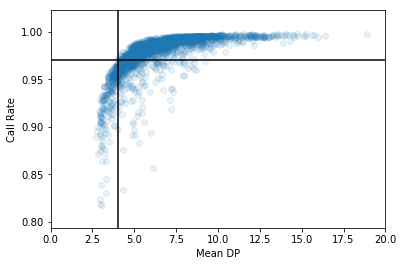

In [23]:
plt.scatter(df["sa.qc.dpMean"], df["sa.qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.axhline(0.97, c='k')
plt.axvline(4, c='k')
plt.show()

It’s easy to filter when we’ve got the cutoff values decided:

In [24]:
vds = vds.filter_samples_expr('sa.qc.dpMean >= 4 && sa.qc.callRate >= 0.97')
print('After filter, %d/1000 samples remain.' % vds.num_samples)

After filter, 1921/1000 samples remain.


Next is genotype QC. To start, we’ll print the post-sample-QC call rate. It’s actually gone up since the initial summary - dropping low-quality samples disproportionally removed missing genotypes.

In [25]:
call_rate = vds.query_genotypes('gs.fraction(g => g.isCalled)')
print('pre QC call rate is %.3f' % call_rate)

pre QC call rate is 0.987


It’s a good idea to filter out genotypes where the reads aren’t where they should be: if we find a genotype called homozygous reference with >10% alternate reads, a genotype called homozygous alternate with >10% reference reads, or a genotype called heterozygote without a ref / alt balance near 1:1, it is likely to be an error.

In [26]:
filter_condition_ab = '''let ab = g.ad[1] / g.ad.sum() in
                         ((g.isHomRef && ab <= 0.1) ||
                          (g.isHet && ab >= 0.25 && ab <= 0.75) ||
                          (g.isHomVar && ab >= 0.9))'''
vds = vds.filter_genotypes(filter_condition_ab)
post_qc_call_rate = vds.query_genotypes('gs.fraction(g => g.isCalled)')
print('post QC call rate is %.3f' % post_qc_call_rate)

post QC call rate is 0.957


Variant QC is a bit more of the same: we can use the variant_qc method to produce a variety of useful statistics, plot them, and filter.

In [27]:
pprint(vds.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     },
     aIndex: Int,
     wasSplit: Boolean
 }


The cache is used to optimize some of the downstream operations.

In [28]:
vds = vds.variant_qc().cache()
pprint(vds.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     },
     aIndex: Int,
     wasSplit: Boolean,
     qc: Struct{
         callRate: Double,
         AC: Int,
         AF: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rHeterozygosity: Double,
         rHetHo

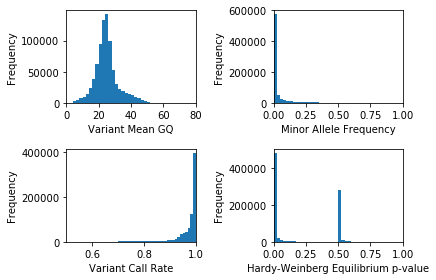

In [29]:
variant_df = vds.variants_table().to_pandas()

plt.clf()
plt.subplot(2, 2, 1)
variantgq_means = variant_df["va.qc.gqMean"]
plt.hist(variantgq_means, bins = np.arange(0, 84, 2))
plt.xlabel("Variant Mean GQ")
plt.ylabel("Frequency")
plt.xlim(0, 80)

plt.subplot(2, 2, 2)
variant_mleaf = variant_df["va.qc.AF"]
plt.hist(variant_mleaf, bins = np.arange(0, 1.05, .025))
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.subplot(2, 2, 3)
plt.hist(variant_df['va.qc.callRate'], bins = np.arange(0, 1.05, .01))
plt.xlabel("Variant Call Rate")
plt.ylabel("Frequency")
plt.xlim(.5, 1)

plt.subplot(2, 2, 4)
plt.hist(variant_df['va.qc.pHWE'], bins = np.arange(0, 1.05, .025))
plt.xlabel("Hardy-Weinberg Equilibrium p-value")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

These statistics actually look pretty good: we don’t need to filter this dataset. Most datasets require thoughtful quality control, though. The filter_variants_expr method can help!

## Let's do a GWAS!

First, we need to restrict to variants that are:

* common (we’ll use a cutoff of 1%)
* uncorrelated (not in linkage disequilibrium)

Both of these are easy in Hail.

In [30]:
common_vds = (vds
              .filter_variants_expr('va.qc.AF > 0.01')
              .ld_prune(memory_per_core=256, num_cores=4))
common_vds.count()

(1921L, 241166L)

These filters removed about 15% of sites (we started with a bit over 10,000). This is NOT representative of most sequencing datasets! We have already downsampled the full thousand genomes dataset to include more common variants than we’d expect by chance.

In Hail, the association tests accept sample annotations for the sample phenotype and covariates. Since we’ve already got our phenotype of interest (caffeine consumption) in the dataset, we are good to go:

In [31]:
gwas = common_vds.linreg('sa.CaffeineConsumption')
pprint(gwas.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     },
     aIndex: Int,
     wasSplit: Boolean,
     qc: Struct{
         callRate: Double,
         AC: Int,
         AF: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rHeterozygosity: Double,
         rHetHo

Looking at the bottom of the above printout, you can see the linear regression adds new variant annotations for the beta, standard error, t-statistic, and p-value.

In [32]:
def qqplot(pvals, xMax, yMax):
    spvals = sorted(filter(lambda x: x and not(isnan(x)), pvals))
    exp = [-log(float(i) / len(spvals), 10) for i in np.arange(1, len(spvals) + 1, 1)]
    obs = [-log(p, 10) for p in spvals]
    plt.clf()
    plt.scatter(exp, obs)
    plt.plot(np.arange(0, max(xMax, yMax)), c="red")
    plt.xlabel("Expected p-value (-log10 scale)")
    plt.ylabel("Observed p-value (-log10 scale)")
    plt.xlim(0, xMax)
    plt.ylim(0, yMax)
    plt.show()

Python makes it easy to make a Q-Q (quantile-quantile) plot.

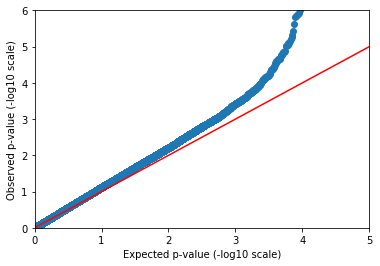

In [33]:
qqplot(gwas.query_variants('variants.map(v => va.linreg.pval).collect()'),
       5, 6)

## Confounded!

The observed p-values drift away from the expectation immediately. Either every SNP in our dataset is causally linked to caffeine consumption (unlikely), or there’s a confounder.

We didn’t tell you, but sample ancestry was actually used to simulate this phenotype. This leads to a stratified distribution of the phenotype. The solution is to include ancestry as a covariate in our regression.

The linreg method can also take sample annotations to use as covariates. We already annotated our samples with reported ancestry, but it is good to be skeptical of these labels due to human error. Genomes don’t have that problem! Instead of using reported ancestry, we will use genetic ancestry by including computed principal components in our model.

The pca method produces sample PCs in sample annotations, and can also produce variant loadings and global eigenvalues when asked.

In [34]:
pca = common_vds.pca('sa.pca', k=5, eigenvalues='global.eigen')
pprint(pca.globals)

{u'eigen': {u'PC1': 110.66162664865941,
            u'PC2': 34.30356468711475,
            u'PC3': 12.76944445570593,
            u'PC4': 9.403800596494895,
            u'PC5': 4.377693585069199}}


In [35]:
pprint(pca.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Double,
     qc: Struct{
         callRate: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         nSNP: Int,
         nInsertion: Int,
         nDeletion: Int,
         nSingleton: Int,
         nTransition: Int,
         nTransversion: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rTiTv: Double,
         rHetHomVar: Double,
         rInsertionDeletion: Double
     },
     pca: Struct{
         PC1: Double,
         PC2: Double,
         PC3: Double,
         PC4: Double,
         PC5: Double
     }
 }


Now that we’ve got principal components per sample, we may as well plot them! Human history exerts a strong effect in genetic datasets. Even with a 50MB sequencing dataset, we can recover the major human populations.

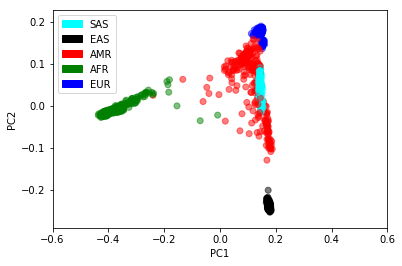

In [36]:
pca_table = pca.samples_table().to_pandas()
colors = {'AFR': 'green', 'AMR': 'red', 'EAS': 'black', 'EUR': 'blue', 'SAS': 'cyan'}
plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"],
            c = pca_table["sa.SuperPopulation"].map(colors),
            alpha = .5)
plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
plt.legend(handles=legend_entries, loc=2)
plt.show()

Now we can rerun our linear regression, controlling for the first few principal components and sample sex.

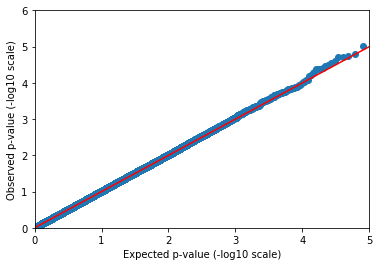

In [37]:
pvals = (common_vds
        .annotate_samples_table(pca.samples_table(), expr='sa.pca = table.pca')
        .linreg('sa.CaffeineConsumption',
                covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.isFemale'],
                use_dosages=True)
        .query_variants('variants.map(v => va.linreg.pval).collect()'))
qqplot(pvals, 5, 6)

That’s more like it! We may not be publishing ten new coffee-drinking loci in Nature, but we shouldn’t expect to find anything but the strongest signals from a dataset of 1000 individuals anyway.

## Rare Variant Analysis

Hail doesn’t yet have rare variant kernel-based methods, but we have linear and logistic burden tests.

We won’t be showing those here, though. Instead, we’ll demonstrate how one can use the expression language to group and count by any arbitrary properties in variant or sample annotatio

In [38]:
kt = (vds.genotypes_table()
         .aggregate_by_key(key_expr=['pop = sa.SuperPopulation', 'chromosome = v.contig'],
                           agg_expr=['n_het = g.filter(g => g.isHet()).count()']))
kt.to_dataframe().show()

+---+----------+-------+
|pop|chromosome|  n_het|
+---+----------+-------+
|AMR|        11| 560791|
|SAS|        16| 618476|
|SAS|         5|1221788|
|EUR|        17| 476009|
|EAS|        10| 777961|
|AMR|         8| 628275|
|AMR|        12| 569166|
|AMR|        22| 156168|
|EAS|        21| 238918|
|AMR|         1| 900855|
|AMR|         4| 849758|
|SAS|         9| 828055|
|EAS|         8| 843228|
|SAS|        13| 699568|
|AMR|        17| 318725|
|SAS|        11| 938998|
|EAS|        18| 447312|
|SAS|         2|1618806|
|AFR|         9|1314917|
|AMR|        10| 584861|
+---+----------+-------+
only showing top 20 rows



What if we want to group by minor allele frequency bin and hair color, and calculate the mean GQ?

In [39]:
kt2 = (vds.genotypes_table()
          .aggregate_by_key(key_expr=['''maf_bin = if (va.qc.AF < 0.01) "< 1%"
                                                   else if (va.qc.AF < 0.05) "1%-5%"
                                                   else "> 5%" ''',
                                     'purple_hair = sa.PurpleHair'],
                           agg_expr=['mean_gq = g.map(g => g.gq).stats().mean',
                                     'mean_dp = g.map(g => g.dp).stats().mean']))

kt2.to_dataframe().show()

+-------+-----------+------------------+-----------------+
|maf_bin|purple_hair|           mean_gq|          mean_dp|
+-------+-----------+------------------+-----------------+
|   < 1%|      false| 23.65247447277473|7.537011270308158|
|   > 5%|      false| 30.94114690592288|6.838393191445045|
|   < 1%|       true|23.419557362528174| 7.45891321759902|
|  1%-5%|      false| 23.86203230433854|7.011309770238716|
|  1%-5%|       true| 23.57440036136899|6.940134276034917|
|   > 5%|       true| 30.73459154199728|6.768009879392383|
+-------+-----------+------------------+-----------------+



We’ve shown that it’s easy to aggregate by a couple of arbitrary statistics. This specific examples may not provide especially useful pieces of information, but this same pattern can be used to detect effects of rare variation:

Count the number of heterozygous genotypes per gene by functional category (synonymous, missense, or loss-of-function) to estimate per-gene functional constraint
Count the number of singleton loss-of-function mutations per gene in cases and controls to detect genes involved in disease